In [1]:
from __future__ import print_function

import os
import sys
sys.path.append('/home/jogi/git/repository/smart_play_set')
from itertools import compress

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import fft, arange, fftpack

from utils.smart_utils import get_dir_path, tensor_to_pandas, load_hdf5_file
from utils.smart_utils import get_array_filenames, split_on_classes, create_row_mask
from preprocessing.process_data import get_data

from utils.plot_utils import plot_spectra_1axis, plot_spectra_3axis
from utils.plot_utils import plot_3axis_raw_signal_1, plot_3axis_raw_signal_compare
from utils.plot_utils import single_file_plots, load_file_to_pandas

from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation
from sklearn.model_selection import cross_val_predict
from ReliefF import ReliefF
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.pipeline import make_pipeline

%matplotlib inline 


/home/jogi/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
def plot_results(cls, scores, acc_stdev, xlabel, ylabel, title):
    # Plot the normalized residual
    n, bins, _ = plt.hist(cls, scores) #, color='y')
    
    mid = 0.5*(bins[1:] + bins[:-1])
    plt.errorbar(mid, n, yerr=acc_stdev, fmt='none')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.title(title)
    plt.show()

In [32]:
train_data_1, train_labels_1, dta_dict_1 = get_data('20160921', force=False, apply_window_func=True, calc_mag=True,
                                              extra_label="20hz_1axis_low8hz_27_13_1", optimal_w_size=False,
                                                   f_type='low', lowcut=8, highcut=0., b_order=5)
                                     
                # calc_mag=True, f_type="lowhigh", lowcut=2, highcut=0.1, b_order=5)
        
# for cross validation train data has to have 2 dim tensor
train_data_1_r = np.reshape(train_data_1, (train_data_1.shape[0], train_data_1.shape[1] * train_data_1.shape[2]))
# for cross validation train labels has to have 1 dim tensor
train_labels_1_r = np.reshape(train_labels_1, (train_labels_1.shape[0]))
print(train_data_1_r.shape)
print(train_labels_1_r.shape)
print(dta_dict_1["features"])
print(dta_dict_1["filter"])
print(dta_dict_1["filter_specs"])
print(dta_dict_1["window_func"])
num_of_features_1 = len(dta_dict_1["features"])
features1 = dta_dict_1["features"]
num_of_windows1 = dta_dict_1["num_of_windows"]

INFO - Used data label 20160921_futurocube_roadrunner_20hz_1axis_low8hz_27_13_1
INFO Loading matrices from h5 file /home/jogi/git/repository/smart_play_set/data/futurocube/roadrunner/20160921_futurocube_roadrunner_20hz_1axis_low8hz_27_13_1.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data'])
INFO - Loading data description from json.
(27, 13)
(27,)
[u'minf', u'maxf', u'mean', u'std', u'median', u'range', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', u'dominant freq', u'dxdy_error']
low
[8, 0.0, 5]
True


In [27]:
train_data_2, train_labels_2, dta_dict_2 = get_data('20160921', force=False, apply_window_func=True, calc_mag=True,
                                              extra_label="20hz_1axis_low8hz_27_12_1", optimal_w_size=False,
                                                   f_type='low', lowcut=8, b_order=5)

# for cross validation train data has to have 2 dim tensor
train_data_2_r = np.reshape(train_data_2, (train_data_2.shape[0], train_data_2.shape[1] * train_data_2.shape[2]))
# for cross validation train labels has to have 1 dim tensor
train_labels_2_r = np.reshape(train_labels_2, (train_labels_2.shape[0]))
print(train_data_2_r.shape)
print(train_labels_2_r.shape)

print(dta_dict_2["features"])
print(dta_dict_2["filter"])
print(dta_dict_2["filter_specs"])
print(dta_dict_2["window_func"])
num_of_features_2 = len(dta_dict_2["features"])
features2 = dta_dict_2["features"]
num_of_windows2 = dta_dict_2["num_of_windows"]

INFO - Used data label 20160921_futurocube_roadrunner_20hz_1axis_low8hz_27_12_1
INFO Loading matrices from h5 file /home/jogi/git/repository/smart_play_set/data/futurocube/roadrunner/20160921_futurocube_roadrunner_20hz_1axis_low8hz_27_12_1.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data'])
INFO - Loading data description from json.
(27, 12)
(27,)
[u'minf', u'maxf', u'mean', u'std', u'median', u'range', u'rms', u'mean_squared_jerk', u'dc', u'energy', u'power_spec_entropy', u'dominant freq']
low
[8, 0.0, 5]
True


In [34]:
use_1 = True
apply_mask = False
classifiers = ['SVM', 'RF', 'XGB', 'GNB']
res_svm_mean = []
res_svm_std = []
res_rfc_mean = []
res_rfc_std = []
res_xgb_mean = []
res_xgb_std = []
res_gnb_mean = []
res_gnb_std = []
kept_feature_lists = []

if use_1:
    print("Use set train_data_1 !")
    dta_train = train_data_1_r
    lbl_train = train_labels_1_r
    num_of_features = num_of_features_1
    features = features1
    num_of_windows = num_of_windows1
else:
    print("Use set train_data_2 !")
    dta_train = train_data_2_r
    lbl_train = train_labels_2_r
    num_of_features = num_of_features_2
    features = features2
    num_of_windows = num_of_windows2

for d in np.arange(num_of_features, 0, -1):
    idx = d
    fs = ReliefF(n_neighbors=10, n_features_to_keep=idx)
    X_train_2 = fs.fit_transform(dta_train, lbl_train)
    X_train_2 = fs.transform(dta_train)
    f_list = [features[i] for i in fs.top_features]
    print("--------------------------------------------------------------")
    print("Keep %d, top feature list: %s" % (idx, ', '.join(f_list[:idx])))
    kept_feature_lists.append(', '.join(f_list[:idx]))

    if apply_mask:
        multiplier = int(X_train_2.shape[0]/num_of_windows)
        b_mask = create_row_mask([False, True, True], multiplier)
        X_train_2 = X_train_2[b_mask, :]
        lbl_train_subset = lbl_train[b_mask]
    else:
        lbl_train_subset = lbl_train
    
    clf = svm.SVC(kernel='rbf', C=1)
    scores_svm = cross_validation.cross_val_score(clf, X_train_2, lbl_train_subset, cv=4)
    # predicted = cross_val_predict(clf, X_train_f, train_labels_f_r, cv=8)
    # print(predicted)
    # scores = accuracy_score(train_labels_r, predicted) 
    print("SVM - Accuracy: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))
    res_svm_mean.append(scores_svm.mean())
    res_svm_std.append(scores_svm.std())
    
    rfc = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)
    scores_rfc = cross_validation.cross_val_score(clf, X_train_2, lbl_train_subset, cv=4)
    print("rfc - Accuracy: %0.2f (+/- %0.2f)" % (scores_rfc.mean(), scores_rfc.std() * 2))
    res_rfc_mean.append(scores_rfc.mean())
    res_rfc_std.append(scores_rfc.std())
    
    xgb = XGBClassifier(learning_rate=0.1, n_estimators=300, max_depth=5, min_child_weight=2, gamma=0.1,
                         subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4,
                         scale_pos_weight=1, seed=27)
    scores_xgb = cross_validation.cross_val_score(clf, X_train_2, lbl_train_subset, cv=4)
    print("xgb - Accuracy: %0.2f (+/- %0.2f)" % (scores_xgb.mean(), scores_xgb.std() * 2))
    res_xgb_mean.append(scores_xgb.mean())
    res_xgb_std.append(scores_xgb.std())
    
    gnb = GaussianNB()
    scores_gnb = cross_validation.cross_val_score(gnb, X_train_2, lbl_train_subset, cv=4)
    print("gnb - Accuracy: %0.2f (+/- %0.2f)" % (scores_gnb.mean(), scores_gnb.std() * 2))
    res_gnb_mean.append(scores_gnb.mean())
    res_gnb_std.append(scores_gnb.std())
    

res_svm_mean = np.asarray(res_svm_mean)
res_svm_std  = np.asarray(res_svm_std)
res_rfc_mean = np.asarray(res_rfc_mean)
res_rfc_std  = np.asarray(res_rfc_std)
res_xgb_mean = np.asarray(res_xgb_mean)
res_xgb_std  = np.asarray(res_xgb_std)
res_gnb_mean = np.asarray(res_gnb_mean)
res_gnb_std  = np.asarray(res_gnb_std)


Use set train_data_1 !
--------------------------------------------------------------
Keep 13, top feature list: dxdy_error, power_spec_entropy, energy, dc, mean_squared_jerk, rms, range, median, std, mean, maxf, minf, dominant freq
SVM - Accuracy: 0.62 (+/- 0.27)
rfc - Accuracy: 0.62 (+/- 0.27)
xgb - Accuracy: 0.62 (+/- 0.27)
gnb - Accuracy: 0.62 (+/- 0.19)
--------------------------------------------------------------
Keep 12, top feature list: dxdy_error, power_spec_entropy, energy, dc, mean_squared_jerk, rms, range, median, std, mean, maxf, minf
SVM - Accuracy: 0.66 (+/- 0.27)
rfc - Accuracy: 0.66 (+/- 0.27)
xgb - Accuracy: 0.66 (+/- 0.27)
gnb - Accuracy: 0.70 (+/- 0.38)
--------------------------------------------------------------
Keep 11, top feature list: dxdy_error, power_spec_entropy, energy, dc, mean_squared_jerk, rms, range, median, std, mean, maxf
SVM - Accuracy: 0.70 (+/- 0.21)
rfc - Accuracy: 0.70 (+/- 0.21)
xgb - Accuracy: 0.70 (+/- 0.21)
gnb - Accuracy: 0.70 (+/- 0.38)

In [51]:
"""
    Finally test the classifier with k-fold crossvalidation on the small data set
    e.g. our current data set consists of N=27 samples
        we use k=9, so each set contains N_k = 3
        so we can build in theory (27 choose 3) different sets of 3 approx 3000 / 9 = 333
        therefore we iterate for 3000 times and average the mean and standard deviation
        
        result:
        (1) 13 features, k=9, 333 iters, using 8 features, SVM
            Accuracy 0.722, sigma 0.218722.3
            
            13 features k=3, 1000 iters, using 8 features, SVM
            Accuracy 0.778, sigma 0.090722.3
            
        
"""
iters = 1000
n_features = 8
class_accuracy = []
class_acc_std = []

fs = ReliefF(n_neighbors=10, n_features_to_keep=n_features)
X_train_2 = fs.fit_transform(dta_train, lbl_train)
X_train_2 = fs.transform(dta_train)

for i in np.arange(iters):

    clf = svm.SVC(kernel='rbf', C=1)
    scores_svm = cross_validation.cross_val_score(clf, X_train_2, lbl_train_subset, cv=3)
    class_accuracy.append(scores_svm.mean())
    class_acc_std.append(scores_svm.std())

total_mean_acc = np.array(class_accuracy).mean()
total_std_acc = np.array(class_acc_std).mean()
print("Accuracy %.3f, sigma %f.3" % (total_mean_acc, total_std_acc))

Accuracy 0.778, sigma 0.090722.3


In [39]:

f_list = [features[i] for i in fs.top_features]
print(X_train_2.shape)

(27, 8)


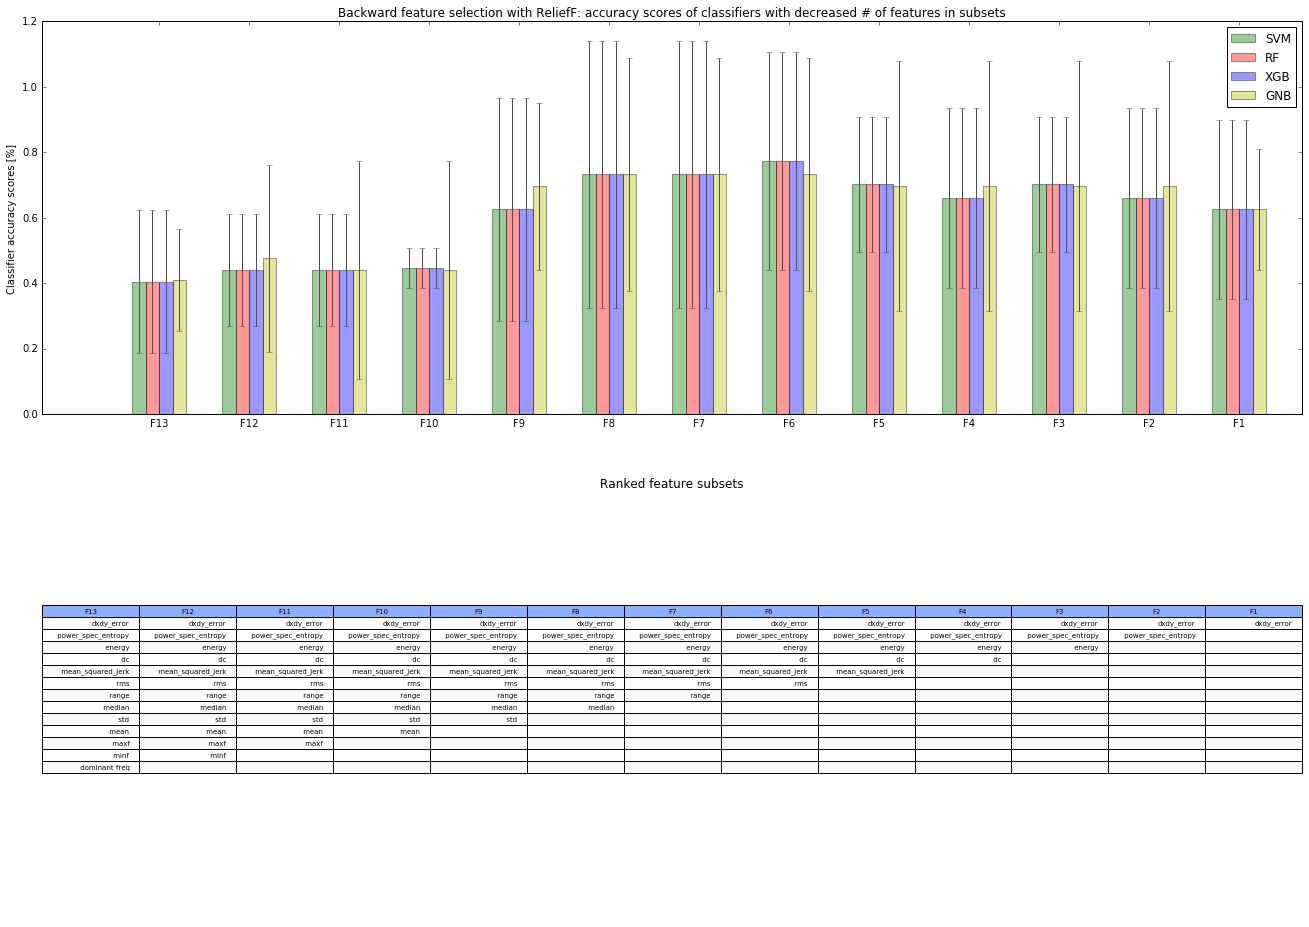

In [20]:
# plot_results(classifiers, scores, std, 'Classifiers', 'Accuracy score', "Classifier accuracy scores")

title = "Backward feature selection with ReliefF: accuracy scores of classifiers with decreased # of features in subsets"
xlabel = 'Ranked feature subsets'
ylabel = "Classifier accuracy scores [%]"
num_of_features = len(res_svm_mean)
bar_width = 0.15
opacity = 0.4
error_config = {'ecolor': '0.3'}
ind = np.arange(num_of_features, 0, -1)

fig, ax = plt.subplots(2,1, figsize=(25, 15))
ax[0].bar(ind, res_svm_mean, bar_width, color='g', yerr=(res_svm_std * 2), label=classifiers[0],
          alpha=opacity, error_kw=error_config)
ax[0].bar(ind + bar_width, res_rfc_mean, bar_width, color='r', yerr=(res_rfc_std * 2), label=classifiers[1],
           alpha=opacity, error_kw=error_config)
ax[0].bar(ind + (2 * bar_width), res_xgb_mean, bar_width, color='b', yerr=(res_xgb_std * 2), label=classifiers[2],
           alpha=opacity, error_kw=error_config)
ax[0].bar(ind + (3 * bar_width), res_gnb_mean, bar_width, color='y', yerr=(res_gnb_std * 2), label=classifiers[3],
           alpha=opacity, error_kw=error_config)

ax[0].set_xticks(np.arange(1, num_of_features+1)+ (2 * bar_width))
x_ticks = ["F" + str(x) for x in ind]
ax[0].set_xticklabels(x_ticks)
# ax[0].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel) 
ax[0].set_title(title)
plt.xticks(rotation=90)
ax[0].legend(loc="best")

f_list_2d = []
for i, f_list in enumerate(kept_feature_lists):
    f_list = f_list.split(',') 
    f_list.extend(" " * (num_of_features - len(f_list)))
    f_list_2d.append(f_list)   # [x for _, x in enumerate (f_list)]

plt.subplots_adjust(left=0.2, bottom=0.1)
f_list_2d = zip(*f_list_2d)
clust_data = np.random.random((num_of_features,num_of_features))
collabel=(x_ticks)
ax[1].axis('tight')
ax[1].axis('off')
ax[1].set_title("Ranked feature subsets")
colors = plt.cm.coolwarm(np.linspace(0.25, 0.25, num_of_features))

the_table = ax[1].table(cellText=f_list_2d,colLabels=collabel,loc='center', colColours=colors)
the_table.set_fontsize(14)
# the_table.scale(1.5, 1.5)
plt.savefig("/home/jogi/git/repository/smart_play_set/images/f_selection_1f.jpg", bbox_inches='tight')



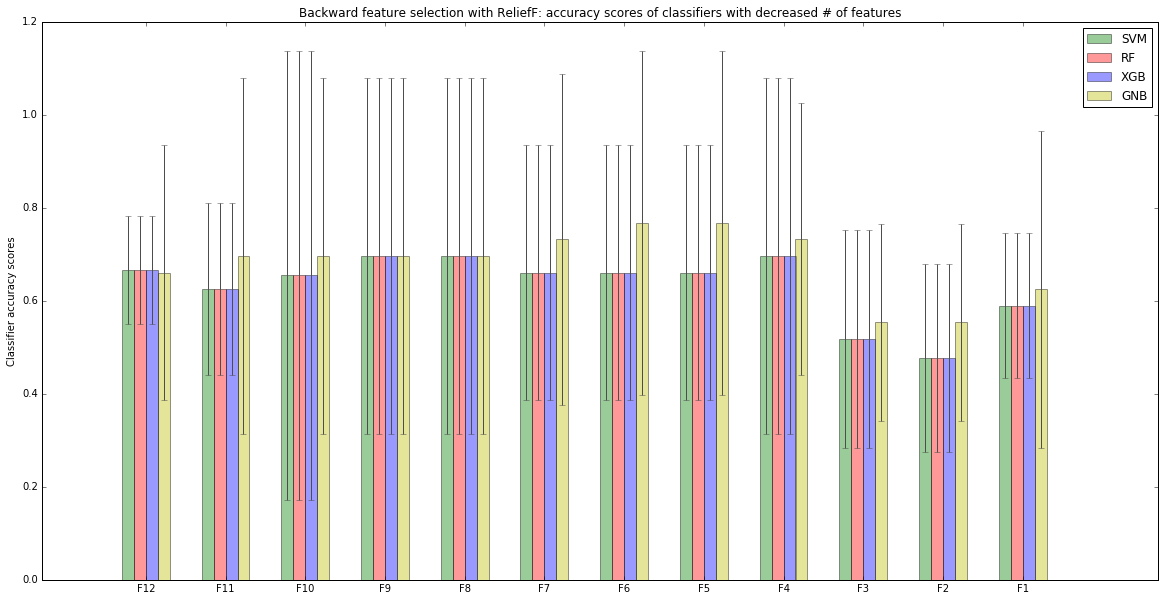

In [30]:
# plot_results(classifiers, scores, std, 'Classifiers', 'Accuracy score', "Classifier accuracy scores")

title = "Backward feature selection with ReliefF: accuracy scores of classifiers with decreased # of features"
xlabel = 'Number of features'
ylabel = "Classifier accuracy scores"
num_of_features = len(res_svm_mean)
bar_width = 0.15
opacity = 0.4
error_config = {'ecolor': '0.3'}
ind = np.arange(num_of_features, 0, -1)
ind = np.arange(1, num_of_features+1)


fig, ax = plt.subplots(figsize=(20, 10))
# NOTE WE NEED TO REVERSE THE ORDER OF THE 
plt.bar(ind, res_svm_mean, bar_width, color='g', yerr=(res_svm_std * 2), label=classifiers[0],
          alpha=opacity, error_kw=error_config)
plt.bar(ind + bar_width, res_rfc_mean, bar_width, color='r', yerr=(res_rfc_std * 2), label=classifiers[1],
           alpha=opacity, error_kw=error_config)
plt.bar(ind + (2 * bar_width), res_xgb_mean, bar_width, color='b', yerr=(res_xgb_std * 2), label=classifiers[2],
           alpha=opacity, error_kw=error_config)
plt.bar(ind + (3 * bar_width), res_gnb_mean, bar_width, color='y', yerr=(res_gnb_std * 2), label=classifiers[3],
           alpha=opacity, error_kw=error_config)

# ax[0].set_xticks(np.arange(1, num_of_features+1)+ (2 * bar_width))
xticks = np.arange(1, num_of_features+1)+ (2 * bar_width)
x_ticks_labels = ["F" + str(x) for x in ind[::-1]]
plt.xticks(xticks, x_ticks_labels)

plt.ylabel(ylabel) 
plt.title(title)
plt.legend(loc="best")

f_list_2d = []
for i, f_list in enumerate(kept_feature_lists):
    f_list = f_list.split(',') 
    f_list.extend(" " * (num_of_features - len(f_list)))
    f_list_2d.append(f_list)   # [x for _, x in enumerate (f_list)]

# transpose 2d list
f_list_2d = zip(*f_list_2d)
clust_data = np.random.random((num_of_features,num_of_features))
collabel=(ind)



plt.savefig("/home/jogi/git/repository/smart_play_set/images/f_selection_12f.jpg", bbox_inches='tight')



In [83]:
use_1 = False 

if use_1:
    print("Use set train_data_1 !")
    dta_train = train_data_1_r
    lbl_train = train_labels_1_r
    num_of_features = num_of_features_1
    features = features1
    num_of_windows = num_of_windows1
else:
    print("Use set train_data_2 !")
    dta_train = train_data_2_r
    lbl_train = train_labels_2_r
    num_of_features = num_of_features_2
    features = features2
    num_of_windows = num_of_windows2

for d in np.arange(1, num_of_features):
    clf = svm.SVC(kernel='linear', C=1)
    selector = RFE(clf, n_features_to_select=d, step=1)
    selector = selector.fit(dta_train, lbl_train)
    support = selector.support_
    feature_ranks = list(compress(features, support))
    print("Keep feature(s) %s" % ", ".join(feature_ranks))
    print(support)
    ranking = selector.ranking_
    print(ranking)
    dta_train_subset = dta_train[:, support]
    multiplier = int(dta_train_subset.shape[0]/num_of_windows)
    b_mask = create_row_mask([True, False, True, False, True], multiplier)
    dta_train_subset = dta_train_subset[b_mask, :]
    lbl_train_subset = lbl_train[b_mask]
    print(dta_train_subset.shape)
    
    clf = svm.SVC(kernel='rbf', C=1)
    scores_svm = cross_validation.cross_val_score(clf, dta_train_subset, lbl_train_subset, cv=3)
    print("SVM - Accuracy: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))
    print("------------------------------------------------------------------")

Use set train_data_2 !
Keep feature(s) int_squared_jerk
[False False False False False False False  True False False False]
[ 6  8  3  7  4 11  9  1  5  2 10]


/home/jogi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27 but corresponding boolean dimension is 45


IndexError: index 27 is out of bounds for axis 0 with size 27

In [84]:


for d in np.arange(1, num_of_features):
    # ANOVA SVM-C
    # 1) anova filter, take X best ranked features, f_classif, mutual_info_classif
    anova_filter = SelectKBest(f_classif, k=d)
    
    dta_train_subset = anova_filter.fit_transform(dta_train, lbl_train)
    print(dta_train_subset.shape)
    # keep selected feature names
    feature_names = [features[i] for i
                             in anova_filter.get_support(indices=True)]
    print("features to keep %s" % ', '.join(feature_names))
    
    # 2) svm
    clf = svm.SVC(kernel='rbf', C=1)
    scores_svm = cross_validation.cross_val_score(clf, dta_train_subset, lbl_train, cv=12)
    print("SVM - Accuracy: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))
    print("------------------------------------------------------------------")


(27, 1)
features to keep int_squared_jerk
SVM - Accuracy: 0.69 (+/- 0.45)
------------------------------------------------------------------
(27, 2)
features to keep minf, int_squared_jerk
SVM - Accuracy: 0.65 (+/- 0.58)
------------------------------------------------------------------
(27, 3)
features to keep minf, int_squared_jerk, power_spec_entropy
SVM - Accuracy: 0.61 (+/- 0.68)
------------------------------------------------------------------
(27, 4)
features to keep minf, int_squared_jerk, energy, power_spec_entropy
SVM - Accuracy: 0.67 (+/- 0.58)
------------------------------------------------------------------
(27, 5)
features to keep minf, rms, int_squared_jerk, energy, power_spec_entropy
SVM - Accuracy: 0.75 (+/- 0.44)
------------------------------------------------------------------
(27, 6)
features to keep minf, mean, rms, int_squared_jerk, energy, power_spec_entropy
SVM - Accuracy: 0.71 (+/- 0.60)
------------------------------------------------------------------
(27,

0.18
